### Identifying Bias

#### **Method 1: Independent Demographic Parity**

#### STEP 1.1: Fit data to a random forest regressor 

In [4236]:
import pandas as pd

df = pd.read_csv('PCA_final.csv')

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
            'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']

In [4237]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (594, 13), y_train shape: (594,)
X_test shape: (255, 13), y_test shape: (255,)


In [4238]:
from sklearn.ensemble import RandomForestRegressor

# Define an Random Forest object using RandomForestRegressor 
rf_model = RandomForestRegressor()

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [4239]:
# Make predictions
y_pred = rf_model.predict(X_test)

#### STEP 1.2: Separate between red and blue states

In [4240]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.00,82664.27,False
357,609983.00,1172488.42,False
110,8302.00,8902.68,False
684,66373.00,105121.24,False
39,11107.00,11870.72,False
...,...,...,...
450,30087.00,18087.89,True
193,3856.00,3438.89,True
795,46705.00,13247.41,True
605,221513.00,177051.15,True


#### STEP 1.3: Calculate Demographic Parity Difference

In [4241]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

# Divide by the number of states
liberal_average_error = liberal_pred_error / 30
conservative_average_error = conservative_pred_error / 20

print(f"Liberal Average Error: {liberal_average_error}")
print(f"Conservative Average Error: {conservative_average_error}")
      
demographic_parity_diff = liberal_average_error - conservative_average_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 232 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 1209.462711442786
Conservative Average Error: 1046.4299545454546
Demographic Parity Difference: 163.0327568973314


#### STEP 1.4: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [4242]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test_p

(is_liberal
 False    3740200983.77
 True    10166305339.78
 dtype: float64,
 is_liberal
 False    61157.18
 True    100828.10
 dtype: float64,
             coverage      bias
 is_liberal                    
 False           0.99  10182.93
 True            1.00 -11939.75)

In [4243]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,3740200983.77,61157.18,0.99,10182.93
Liberal,10166305339.78,100828.10,1.00,-11939.75


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [4244]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.6065490060246456
Disparate Impact (DI) Ratio (Bias): -0.8528593523517676


/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/18864287.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/18864287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/18864287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.inde

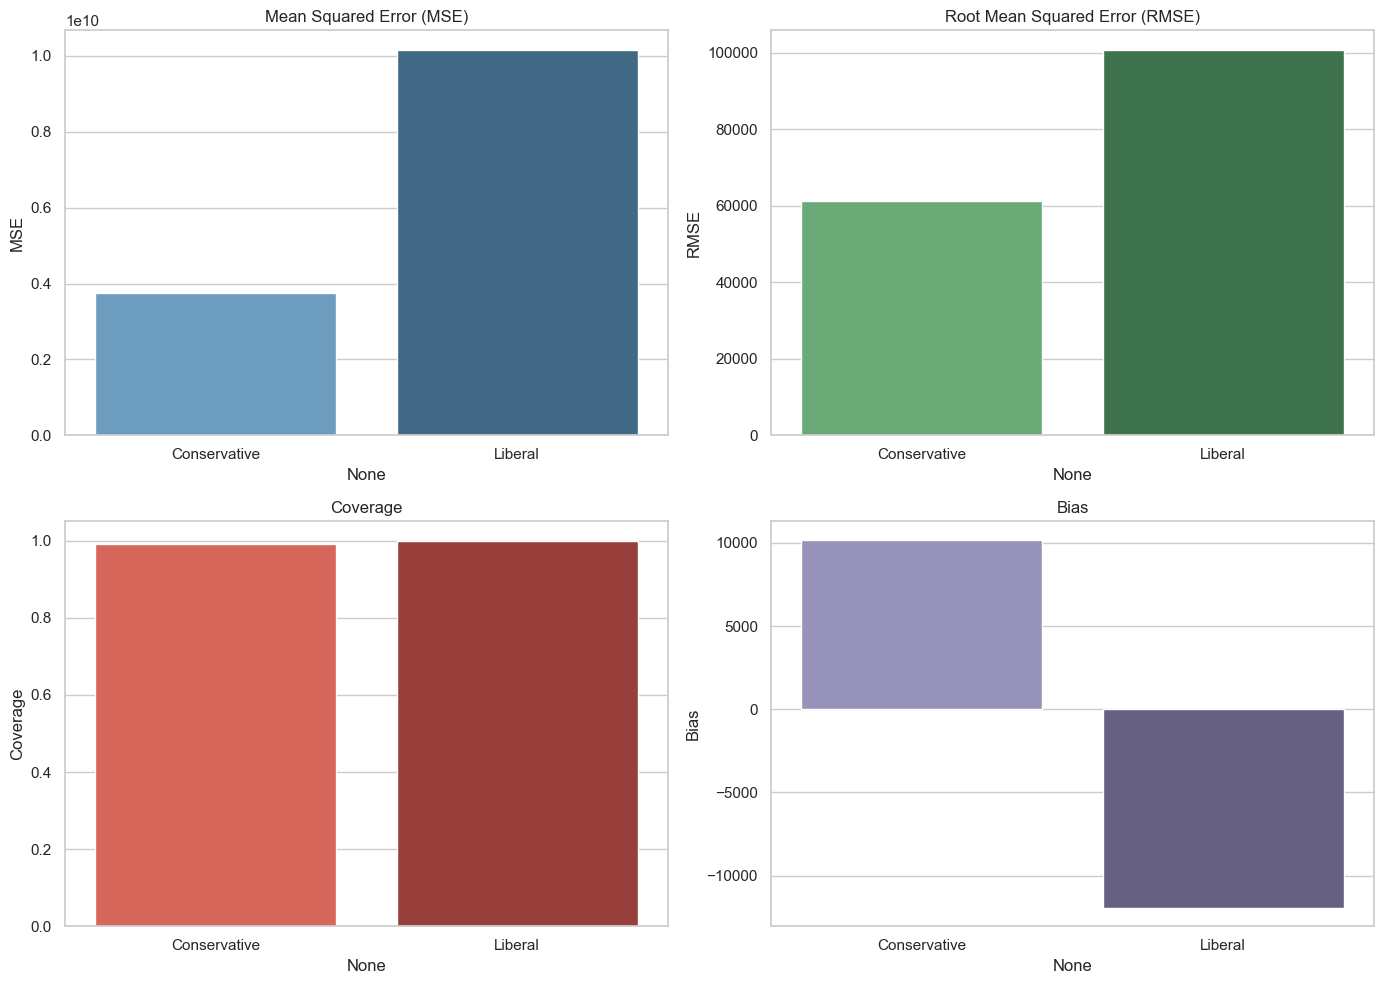

In [4245]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
sns.barplot(x=metrics_df.index, y=metrics_df['MSE'], ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# Plot RMSE
sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'], ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_ylabel('RMSE')

# Plot Coverage
sns.barplot(x=metrics_df.index, y=metrics_df['Coverage'], ax=axes[1, 0], palette="Reds_d")
axes[1, 0].set_title('Coverage')
axes[1, 0].set_ylabel('Coverage')

# Plot Bias
sns.barplot(x=metrics_df.index, y=metrics_df['Bias'], ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title('Bias')
axes[1, 1].set_ylabel('Bias')

# Adjust layout
plt.tight_layout()
plt.show()


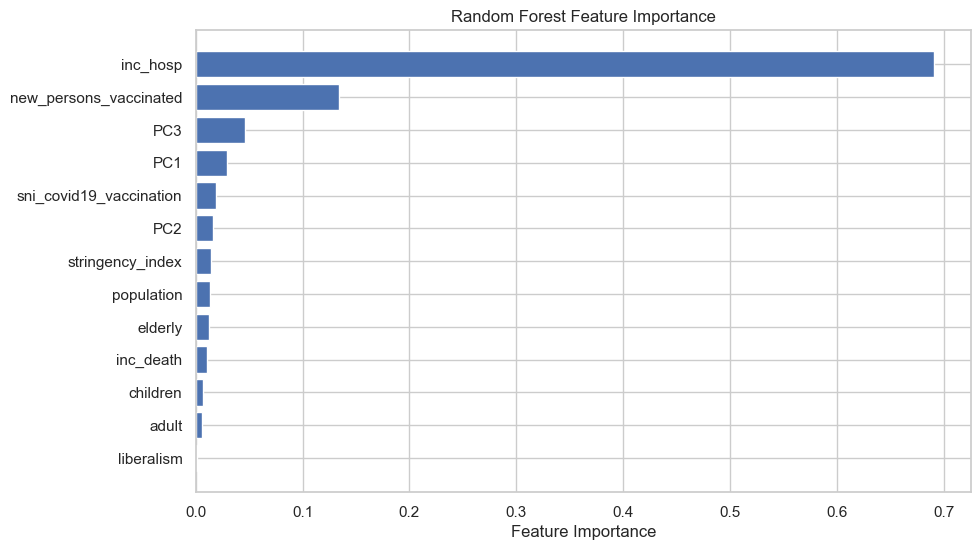

In [4246]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### Method 2: Conditional Independent Demographic Parity

#### STEP 2.1: Create an interaction variable

In [4247]:
df['int:liberalism_stringency'] = df['liberalism'] * df['stringency_category']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3,is_liberal,int:liberalism_stringency
0,2021-01,Alabama,112124.00,1.37,1.58,0.03,0.00,-0.23,-0.24,-0.20,...,-1.01,-0.71,-0.40,1.15,-0.22,-2.40,-0.26,-0.16,False,0.00
1,2021-01,Alaska,8604.00,-0.54,-0.54,1.08,1.00,-0.76,-0.76,-0.85,...,-0.90,-1.32,-0.91,1.94,-0.22,-3.20,0.42,0.07,True,2.00
2,2021-01,Arizona,262750.00,2.37,2.94,1.49,1.00,0.14,0.06,0.17,...,-1.15,-0.30,-1.67,2.11,-0.22,-3.50,0.56,-1.17,True,3.00
3,2021-01,Arkansas,80418.00,0.28,0.47,0.25,0.00,-0.46,-0.48,-0.47,...,-0.87,-0.39,-0.12,1.09,-0.22,-2.13,-0.50,-0.22,False,0.00
4,2021-01,California,1180351.00,10.21,11.82,1.10,1.00,4.45,4.49,4.09,...,-1.05,-1.86,-2.43,2.87,-0.22,-5.16,1.49,-0.31,True,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-05,Virginia,14020.00,-0.45,-0.55,-1.12,1.00,0.24,0.29,0.23,...,-0.15,-0.27,0.71,-0.31,-0.10,0.27,-0.54,0.47,True,1.00
845,2022-05,Washington,15606.00,-0.45,-0.57,-1.06,1.00,0.07,0.12,0.08,...,0.54,0.01,0.42,-1.01,-0.10,1.04,-0.19,0.52,True,1.00
846,2022-05,West Virginia,1726.00,-0.54,-0.57,-1.30,0.00,-0.65,-0.64,-0.62,...,-0.26,1.60,1.08,-1.06,-0.10,1.68,-1.32,-0.81,False,0.00
847,2022-05,Wisconsin,12420.00,-0.47,-0.55,-1.24,0.00,-0.13,-0.12,-0.08,...,1.04,0.43,1.39,-1.34,-0.10,2.60,-0.46,0.82,False,0.00


#### STEP 2.2: Fit data to a random forest regressor 

In [4248]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = df[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_category', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population', 'int:liberalism_stringency']]
y = df['inc_case']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

#### STEP 2.3: Separate between red and blue states

In [4249]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.00,92164.12,False
357,609983.00,978167.33,False
110,8302.00,11810.38,False
684,66373.00,104357.10,False
39,11107.00,13084.82,False
...,...,...,...
450,30087.00,17419.81,True
193,3856.00,3516.65,True
795,46705.00,18108.71,True
605,221513.00,184924.34,True


#### STEP 2.4: Calculate Demographic Parity Difference

In [4250]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

# Divide by the number of states
liberal_average_error = liberal_pred_error / 30
conservative_average_error = conservative_pred_error / 20

print(f"Liberal Average Error: {liberal_average_error}")
print(f"Conservative Average Error: {conservative_average_error}")
      
demographic_parity_diff = liberal_average_error - conservative_average_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 232 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 1217.44402238806
Conservative Average Error: 978.7989462809917
Demographic Parity Difference: 238.64507610706823


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [4251]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test_p

(is_liberal
 False    2167010861.55
 True    10241177514.29
 dtype: float64,
 is_liberal
 False    46551.16
 True    101198.70
 dtype: float64,
             coverage      bias
 is_liberal                    
 False           0.99   9095.16
 True            1.00 -11210.38)

In [4252]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,2167010861.55,46551.16,0.99,9095.16
Liberal,10241177514.29,101198.70,1.00,-11210.38


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [4253]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.45999763311318553
Disparate Impact (DI) Ratio (Bias): -0.8113156914110966


#### STEP 2.6: Calculate Disparate Impact Ratio for red and blue states based on different stringency index category

In [4254]:
interaction_groups = [
    (1, 1), (1, 2), (1, 3),  # Liberal states with stringency categories 1, 2, and 3
    (0, 1), (0, 2), (0, 3)   # Conservative states with stringency categories 1, 2, and 3
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = rf_model.predict(X_test_group)

    mse_group = mean_squared_error(y_test_group, y_pred_group)

    results[(liberalism, stringency)] = mse_group

# Calculate Disparate Impact
DI = {}
for liberalism, stringency in interaction_groups:
    DI[(liberalism, stringency)] = results[(liberalism, stringency)] / results[(1-liberalism, stringency)]

# Convert results to a DataFrame
df_results = pd.DataFrame(DI.items(), columns=['Combination', 'Disparate Impact (DI)'])

print(df_results)

  Combination  Disparate Impact (DI)
0      (1, 1)                   4.49
1      (1, 2)                   7.55
2      (1, 3)                   4.15
3      (0, 1)                   0.22
4      (0, 2)                   0.13
5      (0, 3)                   0.24


#### STEP 2.7: Calculate the evaluation metrics for red and blue states based on different stringency index category

In [4255]:
interaction_groups = [
    (1, 1),
    (1, 2),
    (1, 3),
    (0, 1),
    (0, 2),
    (0, 3)
]

results = {}

for liberalism, stringency in interaction_groups:
    group_mask = (X_test['liberalism'] == liberalism) & (X_test['stringency_category'] == stringency)
    X_test_group = X_test[group_mask]
    y_test_group = y_test[group_mask]
    y_pred_group = rf_model.predict(X_test_group)

    rmse = mean_squared_error(y_test_group, y_pred_group, squared=False)
    mse = mean_squared_error(y_test_group, y_pred_group)
    bias = (y_pred_group - y_test_group).mean()
    coverage = ((y_pred_group >= y_test_group.min()) & (y_pred_group <= y_test_group.max())).mean()

    results[(liberalism, stringency)] = {
        'RMSE': rmse,
        'MSE': mse,
        'Bias': bias,
        'Coverage': coverage
    }

In [4256]:
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Liberalism', 'Stringency Category', 'RMSE', 'MSE', 'Bias', 'Coverage']
results_df['Liberalism'] = results_df['Liberalism'].map({0: 'Conservative', 1: 'Liberal'})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

results_df

,Liberalism,Stringency Category,RMSE,MSE,Bias,Coverage
0,Liberal,1,109889.300,12075658359.189,-25656.950,0.989
1,Liberal,2,53318.799,2842894292.760,6643.457,1.000
2,Liberal,3,123219.258,15182985500.895,46229.808,0.923
3,Conservative,1,51858.993,2689355123.565,6424.520,0.989
4,Conservative,2,19404.946,376551925.949,13507.433,0.966
5,Conservative,3,60467.052,3656264380.303,35860.163,0.500


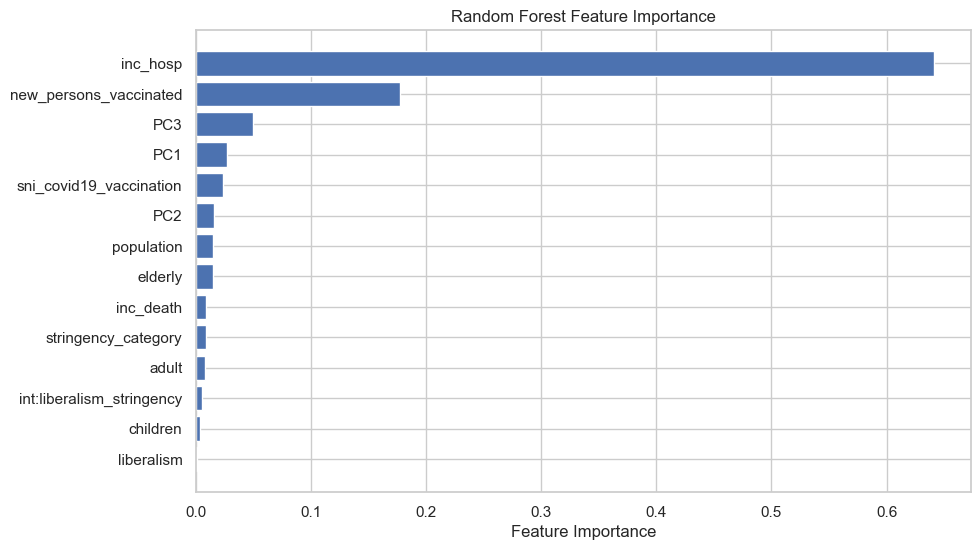

In [4257]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### Mitigating Bias

#### **STEP 1: Add interaction variables**

#### STEP 1.1: Create an interaction variable

In [4258]:
df['int:liberalism_vaccinated'] = df['liberalism'] * df['new_persons_vaccinated']
df['int:stringency_vaccinated'] = df['stringency_index'] * df['new_persons_vaccinated']
df['int:stringency_population'] = df['population'] * df['stringency_index']

display(df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,residential_percent_change_from_baseline,population,PC1,PC2,PC3,is_liberal,int:liberalism_stringency,int:liberalism_vaccinated,int:stringency_vaccinated,int:stringency_population
0,2021-01,Alabama,112124.000,1.371,1.584,0.033,0.000,-0.232,-0.237,-0.199,...,1.150,-0.216,-2.396,-0.262,-0.155,False,0.000,-0.000,-0.057,-0.109
1,2021-01,Alaska,8604.000,-0.537,-0.540,1.081,1.000,-0.755,-0.762,-0.850,...,1.940,-0.216,-3.198,0.417,0.068,True,2.000,-0.391,-0.733,-0.405
2,2021-01,Arizona,262750.000,2.367,2.944,1.492,1.000,0.135,0.060,0.166,...,2.105,-0.216,-3.499,0.563,-1.172,True,3.000,0.209,0.404,-0.416
3,2021-01,Arkansas,80418.000,0.282,0.466,0.248,0.000,-0.459,-0.484,-0.474,...,1.093,-0.216,-2.132,-0.504,-0.224,False,0.000,-0.000,-0.270,-0.385
4,2021-01,California,1180351.000,10.207,11.822,1.098,1.000,4.450,4.492,4.087,...,2.871,-0.216,-5.162,1.488,-0.310,True,3.000,3.106,7.463,-0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,2022-05,Virginia,14020.000,-0.454,-0.553,-1.122,1.000,0.236,0.292,0.235,...,-0.307,-0.098,0.267,-0.542,0.474,True,1.000,-0.437,0.373,0.084
845,2022-05,Washington,15606.000,-0.449,-0.568,-1.060,1.000,0.072,0.117,0.084,...,-1.013,-0.098,1.036,-0.189,0.518,True,1.000,-0.468,0.322,0.068
846,2022-05,West Virginia,1726.000,-0.538,-0.568,-1.299,0.000,-0.653,-0.638,-0.616,...,-1.061,-0.098,1.682,-1.320,-0.813,False,0.000,-0.000,0.357,0.069
847,2022-05,Wisconsin,12420.000,-0.470,-0.547,-1.243,0.000,-0.127,-0.121,-0.077,...,-1.343,-0.098,2.600,-0.461,0.817,False,0.000,-0.000,0.500,0.100


#### **STEP 2: Reweight**

#### STEP 2.1: Count the number of liberal and conservative states

In [4259]:
# Calculate class frequencies
liberal_count = sum(df['liberalism'] == 1)
conservative_count = sum(df['liberalism'] == 0)

# Print the number of liberal and conservative states
print(f"Number of blue states: {liberal_count}, Number of red states: {conservative_count}")

Number of blue states: 441, Number of red states: 408


#### STEP 2.2: Fit data to a random forest regressor with class weights

In [4260]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population',
        'int:liberalism_vaccinated', 'int:stringency_vaccinated', 'int:stringency_population']]
y = df['inc_case']


# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, df.index, test_size=0.3, random_state=42)

# Calculate the sample weights based on the training data
liberal_count_train = sum(df.loc[train_indices]['liberalism'] == 1)
conservative_count_train = sum(df.loc[train_indices]['liberalism'] == 0)

liberal_weight_train = (1 / liberal_count_train) ** 0.5
conservative_weight_train = (1 / conservative_count_train) ** 0.5

# Assign sample weights
sample_weight_train = np.array([liberal_weight_train if label == 1 else conservative_weight_train for label in df.loc[train_indices]['liberalism']])

# Print the weights for liberal and conservative states
print(f"Weight for blue states: {liberal_weight_train}, Weight for red states: {conservative_weight_train}")

# Initialize and fit the RandomForestRegressor with sample weights
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train, sample_weight=sample_weight_train)

"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)"""

Weight for blue states: 0.05707301455353496, Weight for red states: 0.059028133610095526


'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nrf_model = RandomForestRegressor()\nrf_model.fit(X_train, y_train)'

In [4261]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

#### STEP 2.3: Separate between red and blue states

In [4262]:
from sklearn.metrics import mean_squared_error

# Separate the prediction into two groups
df['is_liberal'] = df['liberalism'] > 0

is_liberal = df['is_liberal'].iloc[X_test.index]

# Put the actual and predicted values into a DataFrame
y_test_pred = pd.DataFrame({'actual': y_test, 'predicted': y_pred, 'is_liberal': is_liberal})

display(y_test_pred)

,actual,predicted,is_liberal
512,65893.000,89568.000,False
357,609983.000,1064682.550,False
110,8302.000,9109.230,False
684,66373.000,108045.630,False
39,11107.000,10362.670,False
...,...,...,...
450,30087.000,23069.470,True
193,3856.000,3800.060,True
795,46705.000,20854.780,True
605,221513.000,147643.690,True


#### STEP 2.4: Calculate the Demographic Parity Difference

In [4263]:
# Calculated the absolute average error for liberal and conservative states
liberal_pred = y_test_pred[y_test_pred['is_liberal'] == True]
liberal_pred_error = (abs(liberal_pred['actual'] - liberal_pred['predicted'])).mean()

conservative_pred = y_test_pred[y_test_pred['is_liberal'] == False]
conservative_pred_error = (abs(conservative_pred['actual'] - conservative_pred['predicted'])).mean()

# Divide by the number of states
liberal_average_error = liberal_pred_error / 30
conservative_average_error = conservative_pred_error / 20

print(f"Liberal Average Error: {liberal_average_error}")
print(f"Conservative Average Error: {conservative_average_error}")
      
demographic_parity_diff = liberal_average_error - conservative_average_error
print(f"Demographic Parity Difference: {demographic_parity_diff}")

# Model's predictions are 238 cases more erroneous for liberal states compared to conservative states.

Liberal Average Error: 1231.7554850746271
Conservative Average Error: 1060.5990619834708
Demographic Parity Difference: 171.15642309115628


#### STEP 2.5: Calculate differences between evaluation metrics between liberal (blue) and conservative (red) states

In [4264]:
import numpy as np

def calculate_coverage_bias(actual, predicted):
    coverage = np.mean((predicted >= actual.min()) & (predicted <= actual.max()))
    bias = np.mean(predicted - actual)
    return coverage, bias

grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))

grouped_coverage_bias = y_test_pred.groupby('is_liberal').apply(lambda x: pd.Series(calculate_coverage_bias(x['actual'], x['predicted']), index=['coverage', 'bias']))

grouped_mse = y_test_pred.groupby('is_liberal').apply(lambda x: mean_squared_error(x['actual'], x['predicted']))

grouped_mse, grouped_rmse, grouped_coverage_bias

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_rmse = y_test_pred.groupby('is_liberal').apply(lambda x: np.sqrt(mean_squared_error(x['actual'], x['predicted'])))
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_1953/4027890205.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_coverage_bias = y_test_p

(is_liberal
 False    2978080629.917
 True    10259628115.921
 dtype: float64,
 is_liberal
 False    54571.793
 True    101289.822
 dtype: float64,
             coverage       bias
 is_liberal                     
 False          0.992   9775.512
 True           1.000 -10296.097)

In [4265]:
metrics_df = pd.DataFrame({
    'MSE': grouped_mse,
    'RMSE': grouped_rmse,
    'Coverage': grouped_coverage_bias['coverage'],
    'Bias': grouped_coverage_bias['bias']
})

metrics_df.index = ['Conservative', 'Liberal']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

metrics_df

,MSE,RMSE,Coverage,Bias
Conservative,2978080629.92,54571.79,0.99,9775.51
Liberal,10259628115.92,101289.82,1.00,-10296.10


#### EXTRA STEP: Calculate Disparate Impact Ratio

In [4266]:
rmse_conservative = metrics_df.loc['Conservative', 'RMSE']
rmse_liberal = metrics_df.loc['Liberal', 'RMSE']

# Compute Disparate Impact (DI) ratio using RMSE
DI_ratio = rmse_conservative / rmse_liberal
print("Disparate Impact (DI) Ratio (RMSE):", DI_ratio)

# Compute Disparate Impact (DI) ratio using bias
bias_conservative = metrics_df.loc['Conservative', 'Bias']
bias_liberal = metrics_df.loc['Liberal', 'Bias']   

DI_ratio_bias = bias_conservative / bias_liberal
print("Disparate Impact (DI) Ratio (Bias):", DI_ratio_bias)

Disparate Impact (DI) Ratio (RMSE): 0.5387687733778659
Disparate Impact (DI) Ratio (Bias): -0.9494386574290967


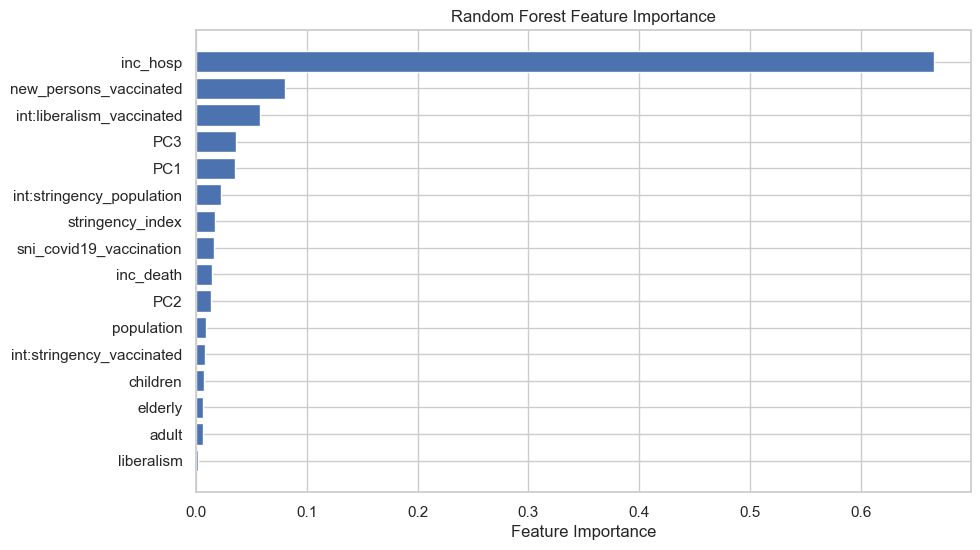

In [4267]:
# Get feature importances from the random forest model
feature_importances = rf_model.feature_importances_

# Get the names of features
feature_names = list(X.columns)

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [4270]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_difference

X = df[['sni_covid19_vaccination', 'new_persons_vaccinated', 'stringency_index', 'inc_death', 'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']]
y = df['inc_case']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train your model (assuming RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate fairness
predictions = model.predict(X_test)
dp_diff_before = demographic_parity_difference(y_test, predictions, sensitive_features=X_test['liberalism'])
print(f"Demographic Parity Difference (Before mitigation): {dp_diff_before}")

# Mitigate bias
constraint = DemographicParity()
mitigator = ExponentiatedGradient(model, constraints=constraint)
mitigator.fit(X_train, y_train, sensitive_features=X_train['liberalism'])
predictions_mitigated = mitigator.predict(X_test)

# Re-evaluate fairness after mitigation
dp_diff_after = demographic_parity_difference(y_test, predictions_mitigated, sensitive_features=X_test['liberalism'])
print(f"Demographic Parity Difference (After mitigation): {dp_diff_after}")


Demographic Parity Difference (Before mitigation): 0.0


ValueError: Supplied y labels are not 0 or 1